In [1]:
import pyprob
from pyprob.distributions import Normal

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Define a query as a regular Python function

In [2]:
def gaussian(obs, sigma=math.sqrt(2), mu0=1, sigma0=math.sqrt(5)):
    mu = pyprob.sample(Normal(mu0, sigma0))
    mu = pyprob.sample(Normal(mu0, sigma0))
    likelihood = Normal(mu, sigma)
    for o in obs:
        pyprob.observe(likelihood, o)
    return mu

In [3]:
gaussian([], 0.01, 2, 0.01)

2.0099734544658356

## Construct inference from query

In [4]:
model = pyprob.Model(gaussian, default_observes=[1,2])

A lazy prior_sample generator:

In [5]:
s = model.prior_sample([7,9])
type(s)

generator

In [6]:
next(s)

-2.3681773744694525

A collection of samples from prior:

In [7]:
model.prior_samples(10, [])

[4.692724357476083,
 0.04092220546944969,
 -0.9380904583102803,
 0.7882243073781954,
 -0.4286282955472249,
 0.028761021603248227,
 5.889802347196291,
 1.8635390405408467,
 4.333378151181317,
 3.6292336740514277]

Inspect traces from prior:

In [8]:
s = model.prior_trace([8, 9])
next(s)

Trace(length:2, samples:[Sample(address_suffixed:12/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[-1.803762435913086]), Sample(address_suffixed:28/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[-0.4260556995868683])], observes_tensor:[[8.0], [9.0]], result:-0.4260557122384494, log_p:-42.49325953596162)

In [9]:
model.prior_traces(3, [8, 9])

[Trace(length:2, samples:[Sample(address_suffixed:12/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[3.028348922729492]), Sample(address_suffixed:28/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[-2.194627046585083])], observes_tensor:[[8.0], [9.0]], result:-2.1946271638472656, log_p:-59.84354933381918),
 Trace(length:2, samples:[Sample(address_suffixed:12/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[0.6867968440055847]), Sample(address_suffixed:28/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[-0.9269425272941589])], observes_tensor:[[8.0], [9.0]], result:-0.926942527085509, log_p:-47.08964695145594),
 Trace(length:2, samples:[Sample(address_suffixed:12/gaussian

## Inference with importance sampling

In [10]:
%time empirical_posterior = model.posterior_samples(10000, [8, 9])

CPU times: user 1.62 s, sys: 20 ms, total: 1.64 s
Wall time: 1.63 s


In [11]:
def true_posterior(x):
    p = Normal(7.25, math.sqrt(1/1.2))
    return math.exp(p.log_pdf(x))

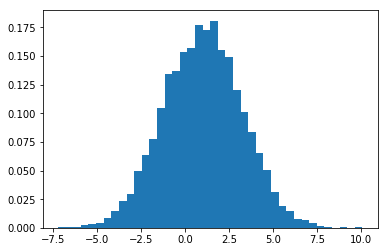

In [12]:
n, bins, patches = plt.hist(empirical_posterior.values,bins=40,normed=True)

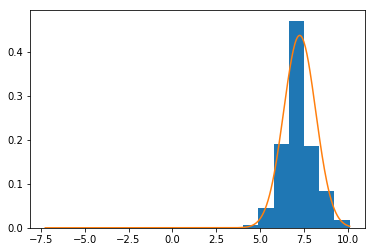

In [ ]:
n, bins, patches = plt.hist(empirical_posterior.values, bins=20,weights=empirical_posterior.weights)
x = np.linspace(min(empirical_posterior.values),max(empirical_posterior.values),400)
plt.plot(x, np.vectorize(true_posterior)(x))

## Inference compilation

In [ ]:
pyprob.set_cuda(True)


────────┬─────────────┬─────────┬─────────────────┬─────────────────
        │ Train. time │   Trace │ Training loss   │ Valid. loss     
────────┼─────────────┼─────────┼─────────────────┼─────────────────
Start   │ 0d:00:00:00 │   0     │ +8.277748e+00   │ +7.890311e+00
Best    │ 0d:00:16:56 │ 575,488 │ +4.137466e+00   │ +4.331822e+00
Current │ 0d:00:16:56 │ 575,488 │ +4.384465e+00   │ +4.342906e+00  
────────┴─────────────┴─────────┴─────────────────┴─────────────────
Training on CUDA, 150 traces/s


## Inference with compiled sequential importance sampling

In [ ]:
%time empirical_posterior = model.posterior_samples(1000, [8, 9])

In [ ]:
n, bins, patches = plt.hist(empirical_posterior.values,bins=40,normed=True)

In [ ]:
n, bins, patches = plt.hist(empirical_posterior.values, bins=20,weights=empirical_posterior.weights)
x = np.linspace(min(empirical_posterior.values),max(empirical_posterior.values),400)
plt.plot(x, np.vectorize(true_posterior)(x))